# Make a slabs_iter

In [2]:
# from the documentation of slabs 

from meshed.slabs import Slabs

from statistics import stdev
vol = stdev
should_turn_movement_sensor_on = lambda audio, light: vol(audio) * light > 50000

def make_a_slabs_iter():

    # Mocking the sensor readers
    audio_sensor_read = iter([[1, 2, 3], [-96, 87, -92], [320, -96, 99]]).__next__
    light_sensor_read = iter([126, 501, 523]).__next__
    movement_sensor_read = iter([None, None, True]).__next__

    return Slabs(
        # The first three components get data from the sensors.
        # The *_read objects are all callable, returning the next
        # chunk of data for that sensor, if any.
        audio=audio_sensor_read,
        light=light_sensor_read,
        movement=movement_sensor_read,
        # The next
        should_turn_movement_sensor_on = lambda audio, light: vol(audio) * light > 50000,
        human_presence_score = lambda audio, light, movement: movement and sum([vol(audio), light]),
        should_notify = lambda human_presence_score: human_presence_score and human_presence_score > 700,
        notify = lambda should_notify: print('someone is there') if should_notify else None
    )


si = make_a_slabs_iter()
next(si)  
    

{'audio': [1, 2, 3],
 'light': 126,
 'movement': None,
 'should_turn_movement_sensor_on': False,
 'human_presence_score': None,
 'should_notify': None,
 'notify': None}

In [3]:
next(si)

{'audio': [-96, 87, -92],
 'light': 501,
 'movement': None,
 'should_turn_movement_sensor_on': True,
 'human_presence_score': None,
 'should_notify': None,
 'notify': None}

# Slabs for stamping press

In [1]:
#Valentin's code
from dataclasses import dataclass
from typing import Iterator
from creek.infinite_sequence import BufferedGetter, OverlapsPastError
from itertools import islice


@dataclass
class TimestampedInfiniteSequence:

    iterator: Iterator
    buffer_len: int

    def __post_init__(self):
        self.buffer_getter = BufferedGetter(self.buffer_len)

    def __getitem__(self, item):
        if isinstance(item, slice):
            items = list(self.buffer_getter)
            
            if not len(items):
                self.buffer_getter.extend(islice(self.iterator, 1))
                return self.__getitem__(item)
            #buffer = AudioData.concatenate(items)
            if item.stop > items[-1]['ts']: #item must have a ts attribute
                self.buffer_getter.extend(islice(self.iterator, 1))
                return self.__getitem__(item)
            if item.start < items[0]['ts']:
                raise OverlapsPastError(
                    f'wrong range'
                    #f'You asked for {item}, but the buffer only contains the index range: {items.start_date}:{items.end_date}'
                )
            
            def query(i: dict):
                #print(f'{item.start=}, {item.stop=}, {i["ts"]=}')
                return item.start <= i['ts'] < item.stop
            
            return self.buffer_getter[query]
        elif isinstance(item, int):
            return self[slice(item, item + 1)][0]

In [25]:
from meshed.slabs import Slabs
from more_itertools import windowed

from typing import Callable

last_plc = None
def filter_on_predicate(data, pred: Callable, event):
    if event is None:
        return 'out1'
    if pred(event):
        return data
    else: 
        return 'out1'

def event_switch(event):
    event['event_a']

def demux(accel, plc):
    result = 'out_1'
    if plc['event_a']:
        result = accel
    return filter_on_predicate(accel, event_switch, plc)


def my_iterator(obj, step = 10):
    for i in range(0, 30, step):
        print(f'{i=}, {i+step=}')
        yield obj[i:i+step]

def make_a_slabs_iter():
    # Sensor readers, slabs of 1 sec
    # use next_slice of creek InfiniteStream instead of iter
    #accelerometer_sensor_read = iter([{'ch1':1, 'ch2':2, 'ch3':3, 'ts':001}, {'ch1':-2, 'ch2':22, 'ch3':43, 'ts':002},
    #                                  {'ch1':92, 'ch2':94, 'ch3':95, 'ts':003}]).__next__
    accelerometer_sensor_read = iter([{'ch1':1, 'ch2':2, 'ch3':3, 'ts':0},{'ch1':1, 'ch2':2, 'ch3':3, 'ts':10}, 
                                             {'ch1':-2, 'ch2':22, 'ch3':43, 'ts':20},{'ch1':92, 'ch2':94, 'ch3':95, 'ts':30},
                                             {'ch1':92, 'ch2':94, 'ch3':95, 'ts':40}])
    accel_buffer = my_iterator(TimestampedInfiniteSequence(accelerometer_sensor_read, buffer_len = 2)).__next__

    # change to an iterator on slices, from 10 to 10
    plc_read = iter([{'var_a':False, 'var_b':False,'ts':0},{'var_a':False, 'var_b':False,'ts':5}, {'var_a':True, 'var_b':False,'ts':10}, 
                        {'var_a':True, 'var_b':True,'ts':15},{'var_a':True, 'var_b':True,'ts':20},
                        {'var_a':True, 'var_b':True,'ts':25},{'var_a':False, 'var_b':True,'ts':30},
                        {'var_a':False, 'var_b':True,'ts':35},{'var_a':False, 'var_b':True,'ts':40}])
    plc_buffer = my_iterator(TimestampedInfiniteSequence(plc_read, buffer_len = 3)).__next__
    
    # pb: what to do with different sample rates? events at the same time! {event_a, event_b}
    return Slabs(
        accel=accel_buffer,
        plc=plc_buffer,
        store_last_plc = lambda plc: set_last_plc(plc[-1]),
        plc_event= lambda plc: list(detect_difference(plc)),
        #demux = lambda accel, plc: filter_on_predicate(accel, event_switch, plc),
        #buffer = lambda demux: windowed(demux, n=2)
    )

def detect_difference(arr):
    if last_plc['var_a'] != arr[0]['var_a']:
        yield 'event_a'
    for x,y in zip(arr, arr[1:]):
        if x['var_a'] != y['var_a']:
            yield 'event_a'

def set_last_plc(value):
    global last_plc    
    last_plc = value



s = make_a_slabs_iter()
next(s)
#next(s)

i=0, i+step=10
i=0, i+step=10


{'accel': [{'ch1': 1, 'ch2': 2, 'ch3': 3, 'ts': 0}],
 'plc': [{'var_a': False, 'var_b': False, 'ts': 0},
  {'var_a': False, 'var_b': False, 'ts': 5}],
 'store_last_plc': None,
 'plc_event': []}

In [3]:
next(s)

i=10, i+step=20
i=10, i+step=20


{'accel': [{'ch1': 1, 'ch2': 2, 'ch3': 3, 'ts': 10}],
 'plc': [{'var_a': True, 'var_b': False, 'ts': 10},
  {'var_a': True, 'var_b': True, 'ts': 15}],
 'store_last_plc': None,
 'plc_event': []}

In [9]:
# sample rate must be the same
# events can occur at the same time
# Valentin: use creek

In [83]:
accelerometer_sensor_iter = iter([{'ch1':1, 'ch2':2, 'ch3':3, 'ts':0},{'ch1':1, 'ch2':2, 'ch3':3, 'ts':10}, {'ch1':-2, 'ch2':22, 'ch3':43, 'ts':20},{'ch1':92, 'ch2':94, 'ch3':95, 'ts':30},{'ch1':92, 'ch2':94, 'ch3':95, 'ts':40}])
accel_buffer = TimestampedInfiniteSequence(accelerometer_sensor_iter, buffer_len = 3)

#plc_sensor_iter = iter([{'var_a':False, 'var_b':False,'ts':5}, {'var_a':True, 'var_b':False,'ts':21}, {'var_a':False, 'var_b':True,'ts':32}])
plc_sensor_iter = iter([{'var_a':False, 'var_b':False,'ts':5}, {'var_a':True, 'var_b':False,'ts':10}, 
                        {'var_a':False, 'var_b':True,'ts':15},{'var_a':False, 'var_b':True,'ts':20},
                        {'var_a':False, 'var_b':True,'ts':25},{'var_a':False, 'var_b':True,'ts':30},
                        {'var_a':False, 'var_b':True,'ts':35},{'var_a':False, 'var_b':True,'ts':40}])

plc_buffer = TimestampedInfiniteSequence(plc_sensor_iter, buffer_len = 3)


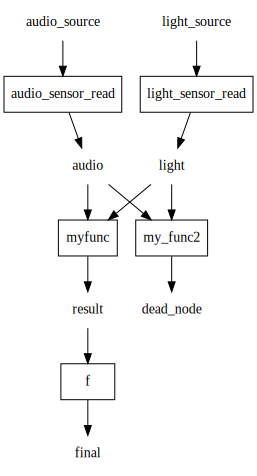

In [84]:
from meshed import code_to_dag

@code_to_dag
def user_story():
    audio = audio_sensor_read(audio_source)
    light = light_sensor_read(light_source)
    result = myfunc(audio, light)
    final = f(result)
    dead_node = my_func2(audio, light)
    

user_story.dot_digraph()

In [52]:
s = make_a_slabs_iter()

In [54]:
list(next(s)['buffer'])

[('ch1', 'ch2'), ('ch2', 'ch3')]

# Using rxpy

In [8]:
import reactivex as rx
from reactivex import operators as ops


letters = rx.from_(["Alpha", "Beta", "Gamma", "Delta", "Epsilon"])
numbers = rx.from_([1,2,3,4,5])

In [11]:
numbers.subscribe(lambda x: print(x))

1
2
3
4
5


In [12]:
letters.pipe(ops.skip_until(numbers.subscribe(print))).subscribe(print)

# letters.pipe(ops.skip_until(lambda s: len(s)), ops.filter(lambda i: i >= 5)).subscribe(
#     lambda value: print("Received {0}".format(value))
# )

1
2
3
4
5


AttributeError: 'Disposable' object has no attribute 'subscribe'

# Using actual data

# plc data:  wav file
# channel data: wav file

In [1]:
# reactive programming in slabs
# start with reading the plc
# do  the async stuff
# you buffer the plc
# how to solve the backpressure problem?
# if None: we do not ignore the input (slabs is a function)
# handling the signals: check the notes
# in meshed: get exceptions

In [2]:
import soundfile as sf
from hear.tools import AudioSegments, AffineConverter

#segs = AudioSegments(src_to_wfsr=sf.read, index_to_seconds_scale=1 / 1e6) #index by microseconds
segs = AudioSegments(src_to_wfsr=sf.read, index_to_seconds_scale=1/50) #index by microseconds


In [3]:
# data
plc_filepath = 'data/PLC.wav'
accel_filepath = 'data/1621346260226336_ch2.wav'

In [4]:
# 59650 samples, at 50 hz = 1193 seconds, ie 19 minutes 53 seconds
plc_data = segs[plc_filepath]
len(plc_data)

59650

In [5]:
# we can query data with bt, tt
len(plc_data[0:1])


1

In [22]:
# from local data to generator

def my_iterator(obj, step = 10):
    for i in range(0, 30, step):
        print(f'{i=}, {i+step=}')
        yield obj[i:i+step]

def mk_data(filepath, channel_name='plc'):
    wf, sr = sf.read(filepath)
    
    index_to_seconds_scale = 1000*1 / sr
    index_to_seconds_offset = 0
    indexer = AffineConverter(
            scale=index_to_seconds_scale, offset=index_to_seconds_offset
        )
    for i, sample in enumerate(wf):
        yield {channel_name:sample, 'ts':indexer(i)}

In [61]:
plc_iter = mk_data(plc_filepath, channel_name='plc')
for i in range(10):
    print(next(plc_iter))

{'plc': 0.0, 'ts': 0.0}
{'plc': 0.0, 'ts': 20.0}
{'plc': 0.0, 'ts': 40.0}
{'plc': 0.0, 'ts': 60.0}
{'plc': 0.0, 'ts': 80.0}
{'plc': 0.0, 'ts': 100.0}
{'plc': 0.0, 'ts': 120.0}
{'plc': 0.0, 'ts': 140.0}
{'plc': 0.0, 'ts': 160.0}
{'plc': 0.0, 'ts': 180.0}


In [39]:
accel_iter = mk_data(accel_filepath, channel_name='accel')
for i in range(10):
    print(next(accel_iter))

{'accel': -0.035858154296875, 'ts': 0.0}
{'accel': -0.022705078125, 'ts': 0.078125}
{'accel': 0.004241943359375, 'ts': 0.15625}
{'accel': 0.0084228515625, 'ts': 0.234375}
{'accel': 0.000823974609375, 'ts': 0.3125}
{'accel': 0.00164794921875, 'ts': 0.390625}
{'accel': -0.01666259765625, 'ts': 0.46875}
{'accel': -0.00811767578125, 'ts': 0.546875}
{'accel': 0.00689697265625, 'ts': 0.625}
{'accel': -0.0010986328125, 'ts': 0.703125}


In [38]:
# check creek more carefully

In [63]:
accelerometer_sensor_read = mk_data(plc_filepath, channel_name='accel')
plc_sensor_read = mk_data(plc_filepath, channel_name='plc')


#slab[10:30]-> all that happens between 10 and 30
#slab[30:50]

plc_buffer = my_iterator(TimestampedInfiniteSequence(plc_sensor_read, buffer_len = 20), step =10)

    # # change to an iterator on slices, from 10 to 10
    # plc_read = iter([{'var_a':False, 'var_b':False,'ts':0},{'var_a':False, 'var_b':False,'ts':5}, {'var_a':True, 'var_b':False,'ts':10}, 
    #                     {'var_a':True, 'var_b':True,'ts':15},{'var_a':True, 'var_b':True,'ts':20},
    #                     {'var_a':True, 'var_b':True,'ts':25},{'var_a':False, 'var_b':True,'ts':30},
    #                     {'var_a':False, 'var_b':True,'ts':35},{'var_a':False, 'var_b':True,'ts':40}])
    # plc_buffer = my_iterator(TimestampedInfiniteSequence(plc_read, buffer_len = 3)).__next__
    
    # # pb: what to do with different sample rates? events at the same time! {event_a, event_b}
    # return Slabs(
    #     accel=accel_buffer,
    #     plc=plc_buffer,
    #     result=accel+plc
    #     store_last_plc = lambda plc: set_last_plc(plc[-1]),
    #     plc_event= lambda plc: list(detect_difference(plc)),
    #     #demux = lambda accel, plc: filter_on_predicate(accel, event_switch, plc),
    #     #buffer = lambda demux: windowed(demux, n=2)
    # )

In [81]:
plc_sensor_read = mk_data(plc_filepath, channel_name='plc')

ts_data = iter(TimestampedInfiniteSequence(plc_sensor_read, buffer_len = 200))


In [82]:
next(ts_data)

{'plc': 0.0, 'ts': 0.0}

## 

In [74]:
plc_sensor_read

<generator object mk_data at 0x7f8feec31070>

In [64]:
list(plc_buffer)

i=0, i+step=10
i=10, i+step=20
i=20, i+step=30


[[{'plc': 0.0, 'ts': 0.0}], [], [{'plc': 0.0, 'ts': 20.0}]]

In [37]:
# change the step size to maybe 100ms
next(accel_buffer)

i=0, i+step=10


[{'plc': 0.0, 'ts': 0.0}]

In [32]:
plc_buffer = TimestampedInfiniteSequence(plc_sensor_iter, buffer_len = 3)


NameError: name 'plc_sensor_iter' is not defined

# Using Andie's stream

### Notes

In [6]:
# careful to use floats with the wfs. 
# rescale the signal
# buffer: keep last two values of signal

### Imports

In [7]:
import time
from functools import partial
from pprint import pprint
from typing import Literal, Sequence, Generator

from audiostream2py.file import WavFileSourceReader
from audiostream2py.data import AudioSegment
from meshed.slabs import Slabs
import numpy as np

from meshed.makers import iterize

#from plunk.ap.snippets import PLUNK_ROOT_PATH

### Data source

In [23]:
#plc_file = PLUNK_ROOT_PATH / 'sb/slabsiter_experiments/data/PLC.wav'
#accel_file = PLUNK_ROOT_PATH / 'sb/slabsiter_experiments/data/1621346260226336_ch2.wav'

plc_file = 'data/PLC.wav'
accel_file = 'data/1621346260226336_ch2.wav'

#assert plc_file.is_file(), f'File not found: {plc_file}'
#assert accel_file.is_file(), f'File not found: {accel_file}'

plc_source = WavFileSourceReader(plc_file, frames_per_buffer=5, start_date=0)
accel_source = WavFileSourceReader(accel_file, frames_per_buffer=12800, start_date=0)

print('plc info:')
pprint(plc_source.info)
print('accel info:')
pprint(accel_source.info)

plc info:
{'bt': 0,
 'channels': 1,
 'frames_per_buffer': 5,
 'n_frames': 59650,
 'rate': 50,
 'width': 2}
accel info:
{'bt': 0,
 'channels': 1,
 'frames_per_buffer': 12800,
 'n_frames': 15270400,
 'rate': 12800,
 'width': 2}


### Classes

In [9]:
class BoolSegmentEdgeDetector:
    last_sample_of_previous_segment = None
    
    def detect_edge_indices(
        self, bool_segment: np.ndarray[bool], edge_type: Literal['rising', 'falling', 'both']
    ) -> list:
        if edge_type not in ['rising', 'falling', 'both']:
            raise ValueError(
                "Valid values for edge_type parameter are 'rising', 'falling', and 'both'."
            )
        if self.last_sample_of_previous_segment is not None:
            bool_segment = np.insert(bool_segment, 0, self.last_sample_of_previous_segment)
        self.last_sample_of_previous_segment = bool_segment[-1]

        int_segment = bool_segment.astype(int)
        edges = np.diff(int_segment)
        if edge_type == 'rising':
            return np.nonzero(edges == 1)[0].tolist()
        elif edge_type == 'falling':
            return np.nonzero(edges == -1)[0].tolist()
        else:
            return np.nonzero(edges)[0].tolist()


class AudioSegmentBuffer:
    write_state = False
    buffered_segment = AudioSegment.empty()

    def read_values(self, ts):
        if not self.write_state:
            self.write_state = True
            return None
        values = self.buffered_segment[:ts]
        self.buffered_segment = self.buffered_segment[ts:]
        return values

    def write_values(self, incoming_segment: AudioSegment):
        if self.write_state:
            self.buffered_segment += incoming_segment


TypeError: Too few arguments for numpy.ndarray

In [22]:
import numpy as np
import numpy.typing as npt

# def as_array(a: npt.ArrayLike[bool]) -> np.ndarray:
#     return np.array(a)

def as_array(a: np.ndarray) -> np.ndarray:
    return np.array(a)

### Generic functions

In [27]:
a = np.array([1,2,0,1,2,0])
bool(a)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [1]:
def get_bytes_of_audio_segment(audio_segment: AudioSegment) -> bytes:
    return audio_segment.waveform

def convert_bytes_to_array(bytes_: bytes, dtype: type) -> np.ndarray:
    return np.frombuffer(bytes_, dtype=dtype)

def convert_array_to_bool(array: np.ndarray) -> np.ndarray:
    return array != 0  

def instantiate_rising_edge_detector() -> callable:
    return partial(BoolSegmentEdgeDetector().detect_edge_indices(edge_type='rising'))

def get_index_of_event(event_detector: callable, data_segment: np.ndarray) -> list[int]:
    return event_detector(data_segment)

# Should we use generators starting from here? How to separate that concern??

def get_audio_ts_from_index(audio_segment: AudioSegment, index: int) -> tuple:
    return audio_segment.get_ts_of_frame_index(index)

def get_bt_of_ts(ts: tuple):
    return ts[0]

def instanciate_audio_segment_buffer():
    return AudioSegmentBuffer()

def write_to_buffer(buffer, audio_segment: AudioSegment) -> None:
    buffer.write_values(audio_segment)

def read_buffer(buffer, ts) -> AudioSegment:
    return buffer.read_values(ts)

def convert_bytes_to_floats(bytes_: bytes):
    pass
    # Use recode here
    # wf = np.array(decode_pcm_bytes(wf_bytes)

def first_featurizer(audio_segments: list[AudioSegment]) -> list[float]:
    pass

# def find_wf_at_event(wf_buffer, plc_event: AudioSegment):
#     if plc_event is None:
#         return
#     event_start = plc_event.start_date
#     event_end = plc_event.end_date
#     return np.frombuffer(wf_buffer[event_start:event_end].waveform, dtype=np.int16)
#     #return wf_buffer[event_start:event_end].waveform


NameError: name 'AudioSegment' is not defined

In [53]:
from creek import BufferStats
from collections import deque
from recode import decode_pcm_bytes


def identity(x):
    return x
bs = BufferStats(values = (-1,-1),maxlen=2, func=identity) #, add_new_val=deque.appendleft)


In [63]:
def simple_plot(arr):
    length = len(arr)
    result = [["0"]*length, ["0"]*length]   
    for i, val in enumerate(arr):
        if val:
            result[0][i] = "*"
            result[1][i] = "*"
    result.append(["-"]*length)
    print('\n'.join([''.join(row) for row in result]))

In [75]:
from creek import BufferStats
from collections import deque
from recode import decode_pcm_bytes


def simple_plot(arr):
    length = len(arr)
    result = [["0"]*length, ["0"]*length]   
    for i, val in enumerate(arr):
        if val:
            result[0][i] = "*"
            result[1][i] = "*"
    result.append(["-"]*length)
    print('\n'.join([''.join(row) for row in result]))

def identity(x):
    return x
bs = BufferStats(values = (-1,-1),maxlen=2, func=identity) #, add_new_val=deque.appendleft)

# SLABS
counter = 0
with accel_source.stream_buffer(maxlen=None) as accel_buffer:
    accel_reader = accel_buffer.mk_reader()
    
    with plc_source.stream_buffer(maxlen=None) as plc_buffer:
        plc_reader = plc_buffer.mk_reader()
        time.sleep(1)
        next_plc = partial(plc_reader.next, ignore_no_item_found=True)

        slabs = Slabs(
            wf_buffer = lambda: accel_reader,
            # output = my_func(input)
            plc_segment = next_plc,
            last_plc = lambda plc_segment: plc_segment.waveform[-1] ,
            view_segment = lambda plc_segment: plc_segment.waveform,
            int_segment = lambda plc_segment: np.array(decode_pcm_bytes(plc_segment.waveform)),
            bool_segment = lambda int_segment: (int_segment != 0).astype(int),
            buffered_last = lambda bool_segment: bs(bool_segment[-1]), #(previous_last, current_last),

            edges = lambda bool_segment, buffered_last: np.diff(bool_segment, prepend=buffered_last[0]),
            edges_ones_idx = lambda edges: [i for i, x in enumerate(edges) if x == 1],
            ts_for_edge_one = lambda edges_ones_idx, plc_segment: [get_audio_ts_from_indices(plc_segment, i) for i in edges_ones_idx],
            #rising_edges_count_mod_2 = lambda edges: sum(x % 2 for x in edges if x==1),
            #bool_plot = lambda bool_segment: simple_plot(bool_segment),

            #sink = lambda last_plc: print(last_plc)
        )

        for s in slabs:
            counter +=1
            print(f'segment={s.get("bool_segment")} edges={s.get("edges")} edges_ones_idx={s.get("edges_ones_idx")} ts_for_edge_one={s.get("ts_for_edge_one")}')
            #print(f'{s.get("edges")}')

            if counter>15:
                break
            #if fvs is not None,:
            #    print(f'{s.get('fvs')}')
            # if (fvs := s.get('fvs')) is not None: 
            #     print(fvs)

segment=[0 0 0 0 0] edges=[0 0 0 0 0] rising_edges_count_mod_2=0
segment=[0 0 0 0 0] edges=[0 0 0 0 0] rising_edges_count_mod_2=0
segment=[0 0 0 0 0] edges=[0 0 0 0 0] rising_edges_count_mod_2=0
segment=[0 0 0 0 0] edges=[0 0 0 0 0] rising_edges_count_mod_2=0
segment=[0 0 0 0 0] edges=[0 0 0 0 0] rising_edges_count_mod_2=0
segment=[0 0 0 0 0] edges=[0 0 0 0 0] rising_edges_count_mod_2=0
segment=[0 0 0 0 0] edges=[0 0 0 0 0] rising_edges_count_mod_2=0
segment=[0 0 0 0 0] edges=[0 0 0 0 0] rising_edges_count_mod_2=0
segment=[0 0 0 0 0] edges=[0 0 0 0 0] rising_edges_count_mod_2=0
segment=[0 0 0 0 0] edges=[0 0 0 0 0] rising_edges_count_mod_2=0
segment=[0 0 0 0 0] edges=[0 0 0 0 0] rising_edges_count_mod_2=0
segment=[0 0 0 0 1] edges=[0 0 0 0 1] rising_edges_count_mod_2=1
segment=[1 0 0 0 0] edges=[ 0 -1  0  0  0] rising_edges_count_mod_2=0
segment=[0 0 0 0 0] edges=[0 0 0 0 0] rising_edges_count_mod_2=0
segment=[0 0 0 0 0] edges=[0 0 0 0 0] rising_edges_count_mod_2=0
segment=[0 0 0 0 0] 

In [67]:
np.diff([False, False, False,  True])

array([False, False,  True])

In [52]:
decode_pcm_bytes(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
)

[0, 0, 0, 0, 0]